In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [3]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
import tensorflow as tf


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# for directory in os.listdir('data/lfw'):
#     for file in os.listdir(os.path.join('data/lfw', directory)):
#         EX_PATH = os.path.join('data/lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [7]:
import uuid

In [8]:
import cv2
import os
import uuid

# cap = cv2.VideoCapture(0)

# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250, 200:200+250, :]

#     # Collect anchors
#     if cv2.waitKey(1) & 0xFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)

#     # Collect positives
#     if cv2.waitKey(1) & 0xFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)

#     if not ret:
#         break

#     cv2.imshow('image Collection', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


In [9]:
anchor   = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()
dir_test = dir_test.next()
print(dir_test)

b'data\\anchor\\2880715f-4c64-11f0-a7ec-9061ae954920.jpg'


In [11]:
def preprocess(file_path):
    # read a image file
    byte_img = tf.io.read_file(file_path)
    # decode it into tenso with 3 channels (rgb)
    img = tf.image.decode_jpeg(byte_img)
    # preprocessing steps - rsizing the imge to 100*100
    img = tf.image.resize(img,(100,100))
    # scale image to be between 0 and1
    img = img/255.0
    return img


In [12]:
img= preprocess(dir_test)

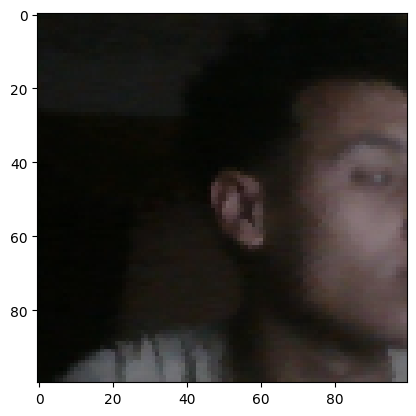

In [13]:
plt.imshow(img)

In [14]:
positives = tf.data.Dataset.zip((anchor, positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
def preprocess_twin(input_img,validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
round(len(data))

600

In [18]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [20]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Build an embadding layer


In [21]:
def make_embedding():
    input_ = input_shape = Input(shape=(100, 100, 3), name='input_image')

    c1 = Conv2D(64,(10,10),activation='relu')(input_)
    p1 = MaxPooling2D(64,(2,2),padding='same')(c1)

    c2 = Conv2D(128,(7,7),activation='relu')(p1)
    p2 = MaxPooling2D(64,(2,2),padding='same')(c2)

    c3 = Conv2D(128,(4,4),activation='relu')(p2)
    p3 = MaxPooling2D(64,(2,2),padding='same')(c3)

    c4 = Conv2D(256,(4,4),activation='relu')(p3)
    flat = Flatten()(c4)
    dense = Dense(4096, activation='sigmoid')(flat)


    return Model(inputs=input_, outputs=dense, name='embedding')
     


In [22]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

create an L1 Distance Layer

In [23]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

Compile the Siamese Network 


In [24]:
def make_siamese_model():
    input_image = Input(shape=(100, 100, 3), name='input_image')
    validation_image = Input(shape=(100, 100, 3), name='validation_image')

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distance = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distance)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese_model')

1. Set Up a Loss Function

In [25]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

2. Set Up an Optimizer


In [26]:
opt = tf.keras.optimizers.Adam(1e-4)


In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
siamese_model = make_siamese_model()  # ← نفّذ الدالة فعلاً

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


3. Build a Custom Training Loop

In [28]:
@tf.function
def train_step (batch):
    with tf.GradientTape() as tape:
        x = batch[:2]
        y_ture = batch[2]
        y_pred = siamese_model(x, training=True)
        loss = binary_cross_loss(y_ture, y_pred)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

4. Creat a Training Loop

In [29]:
def train(data, EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        # loop through the batches
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print('Saved checkpoint for epoch {}: {}'.format(epoch, checkpoint_prefix))

5. Train the Model


In [30]:
EPOCHES = 1
train(train_data, EPOCHES)

Epoch 1/1
27/27 [==============================] - 576s 21s/step
